# Interfacing between the MuPT molecular representation and RDKit

[19:10:18] UFFTYPER: Unrecognized atom type: *_ (4)
[19:10:18] UFFTYPER: Unrecognized atom type: *_ (24)


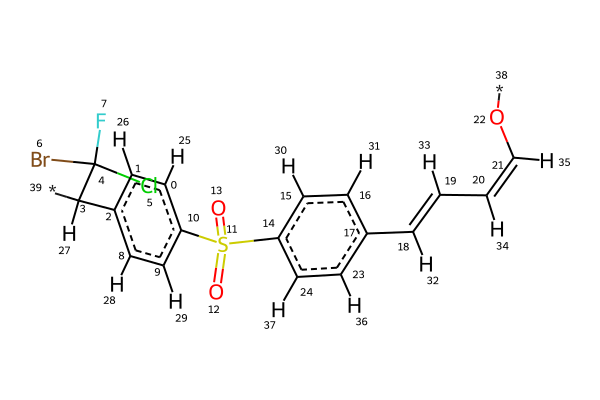

Primitive(shape=PointCloud, functionality=2, topology=TopologicalStructure(num_objects=38, indiscrete=False), element=None, label=*OC([H])=C([H])C([H])=C([H])c1c([H])c([H])c(S(=O)(=O)c2c([H])c([H])c(C(*)([H])[C@@](F)(Cl)Br)c([H])c2[H])c([H])c1[H])
38 2
Conformer shape: (38, 3)


{('Conn',
  1): ConnectorReference(primitive_handle=('ATOM', 23), connector_handle=('Conn', 1)),
 ('Conn',
  2): ConnectorReference(primitive_handle=('ATOM', 3), connector_handle=('Conn', 1))}

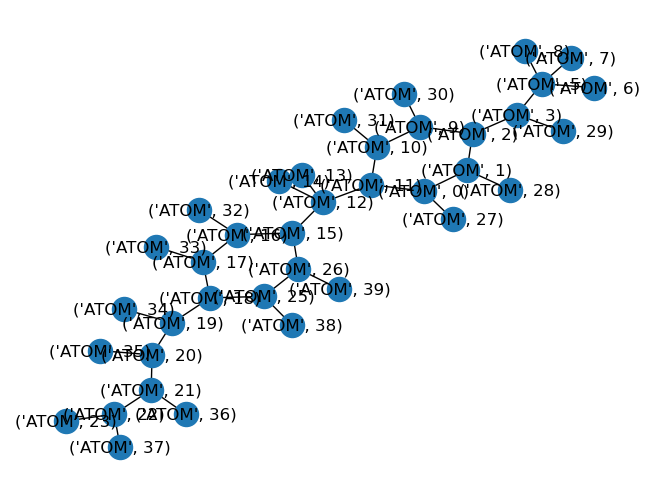

In [1]:
from mupt.interfaces.rdkit import primitive_from_rdkit, primitive_to_rdkit
from mupt.interfaces.smiles import primitive_from_smiles
from mupt.geometry.shapes import PointCloud


smi = '*CC(=O)O*'
# smi = 'c1cc(*)ccc1-S(=O)(=O)-c1ccc(O-*)cc1' # PPS middle repeat unit
# smi = 'c1cc(*)ccc1-S(=O)(=O)-c1ccc(O-*)cc1.*CC(=O)O*' # combination of previous two
smi = 'c1cc(C(-*)([C@@](Cl)(Br)(F)))ccc1-S(=O)(=O)-c1ccc(C=CC=CO-*)cc1' # PPS with stereochemistry-testing halogenated methyl
# smi = 'c1cc(C([C@](Cl)(Br)(F)))ccc1-S(=O)(=O)-c1ccc(C=CCO)cc1'
# smi = r'C[C@H](CCCC(C)C)[C@H]1CC[C@@H]2[C@@]1(CC[C@H]3[C@H]2CC=C4[C@@]3(CC[C@@H](C4)O)C)C' # cholesterol
# smi = r'C/C=C(/C)\C(=O)O[C@H]1C(C)=C[C@]23[C@]1(O)[C@H](O)C(CO)=C[C@H](C3=O)[C@H]4[C@H](C4(C)C)C[C@H]2C' # ingenol
# smi = '*-OC[C@H]1OC=C[C@@H](O)[C@@H]1O-*'

prim = primitive_from_smiles(smi, ensure_explicit_Hs=True, embed_positions=True)
mol = primitive_to_rdkit(prim)

display(mol)
print(repr(prim))
print(prim.num_atoms, prim.functionality)
if isinstance(prim.shape, PointCloud):
    print(f'Conformer shape: {prim.shape.positions.shape}')
# display(prim.connectors)
display(prim.external_connectors)
prim.visualize_topology()

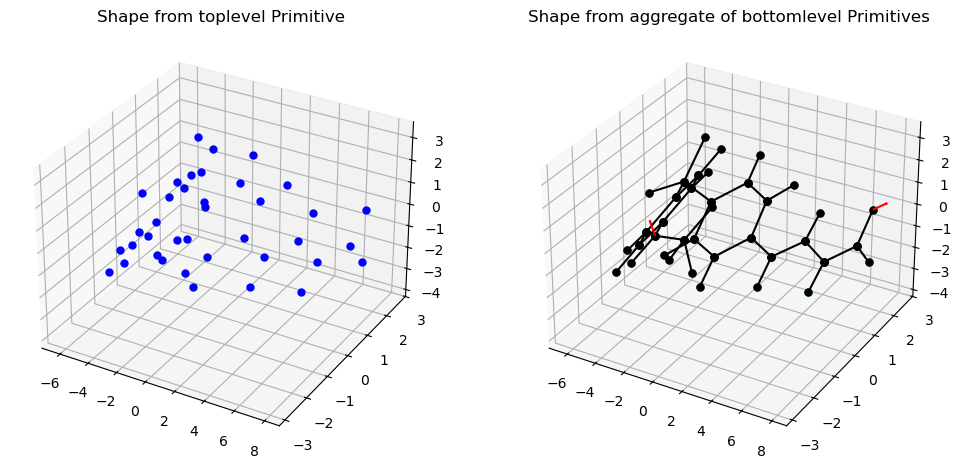

In [2]:
## Visualize connections within Primitive
import matplotlib.pyplot as plt
import numpy as np


dim : float = 6
n_rows, n_cols = 1, 2
aspect = n_cols / n_rows
figsize = (aspect*dim, dim)

fig = plt.figure(figsize=figsize)
ax0 = fig.add_subplot(1, 2, 1, projection='3d')
ax0.set_title('Shape from toplevel Primitive')
if prim.shape is not None:
    _ = ax0.plot(*prim.shape.positions.T, 'o', markersize=5, color='b')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.set_title('Shape from aggregate of bottomlevel Primitives')
for subprim in prim.children:
    if subprim.shape is not None:
        _ = ax1.plot(*subprim.shape.positions.T, 'o-', markersize=5, color='g')
        
for (label1, label2) in prim.topology.edges:
    subprim1 = prim.children_by_handle[label1]
    subprim2 = prim.children_by_handle[label2]
    edge_endpoints = np.vstack([subprim1.shape.positions, subprim2.shape.positions])
    
    _ = ax1.plot(*edge_endpoints.T, 'o-', markersize=5, color='k')#, markersize=5, color='g')
    
for handle, connector in prim.connectors.items():
    ax1.quiver(*connector.anchor_position, *connector.bond_vector, color='r', arrow_length_ratio=0.1)

In [8]:
for subprim in prim.children:
    print(subprim)
    print(repr(subprim))
    
    # for connector in subprim.connectors.values():
    #     if connector.has_dihedral_orientation:
    #         print(connector.tangent_vector)
    #         print(connector)

C(SINGLE:1-AROMATIC:2)[shape=PointCloud]<graph_hash=5740354900026072187>-0
Primitive(shape=PointCloud, functionality=3, topology=TopologicalStructure(num_objects=0, indiscrete=True), element=C, label=0)
C(SINGLE:1-AROMATIC:2)[shape=PointCloud]<graph_hash=5740354900026072187>-1
Primitive(shape=PointCloud, functionality=3, topology=TopologicalStructure(num_objects=0, indiscrete=True), element=C, label=1)
C(SINGLE:1-AROMATIC:2)[shape=PointCloud]<graph_hash=5740354900026072187>-2
Primitive(shape=PointCloud, functionality=3, topology=TopologicalStructure(num_objects=0, indiscrete=True), element=C, label=2)
C(SINGLE:4)[shape=PointCloud]<graph_hash=5740354900026072187>-3
Primitive(shape=PointCloud, functionality=4, topology=TopologicalStructure(num_objects=0, indiscrete=True), element=C, label=3)
C(SINGLE:4)[shape=PointCloud]<graph_hash=5740354900026072187>-5
Primitive(shape=PointCloud, functionality=4, topology=TopologicalStructure(num_objects=0, indiscrete=True), element=C, label=5)
Cl(SING

## Export to RDKit

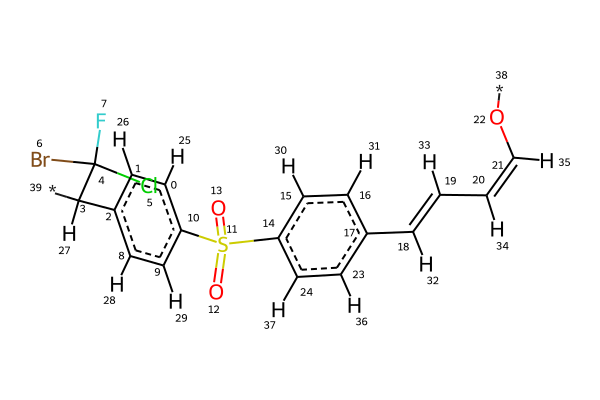

In [4]:
from mupt.interfaces.rdkit import primitive_to_rdkit

outmol = primitive_to_rdkit(prim)
display(outmol)

N.B: all unset atom positions (e.g. when no conformer is provided) will be collapsed to the same point (by default the origin)  
Depending on how small the molecule is, these can be nevertheless recovered by RDKit's coordinate embedding

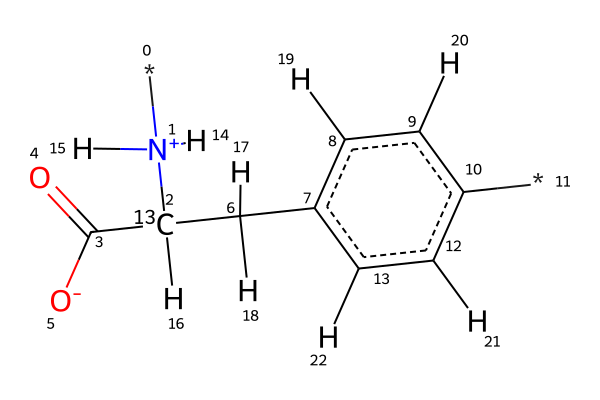

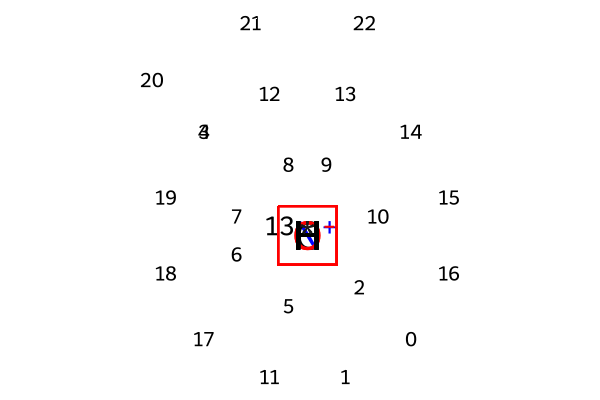

In [6]:
from rdkit import Chem

# zwitterionic phenylalanine
smi = '*-[NH2+][13CH](C(=O)[O-])Cc1ccc(-*)cc1'
mol = Chem.MolFromSmiles(smi)
mol = Chem.AddHs(mol)
display(mol)

newprim = primitive_from_rdkit(mol)
outmol = primitive_to_rdkit(newprim)
display(outmol)

In [ ]:
from rdkit.Chem.rdDepictor import Compute2DCoords

conf_id = Compute2DCoords(outmol)
display(outmol)